# Processing all session data _with Random Cut_ and predict subject emotion with LDA

## Set up

In [1]:
import os
import glob
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from get_feature_response import *

# figure size in inches: 
# https://stackoverflow.com/questions/31594549/
# how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
rcParams['figure.figsize'] = 11.7,8.27

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xxonnmvy because the default path (/home/chc012/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
CATEGORIES = {
    (0, 0) : "lvla",
    (0, 1) : "lvha",
    (1, 0) : "hvla",
    (1, 1) : "hvha"
}

min_record_len = 35

### Get preprocessed data

In [3]:
raw_path = "raw"
all_sessions = os.listdir(raw_path)

loaded_raws = []
for session in all_sessions:
    session_path = os.path.join(raw_path, session)
    with open(session_path, "rb") as fp:
        raw = pickle.load(fp)
    loaded_raws.append(raw)

### Get emotion response

In [4]:
dataset_path = "/net2/expData/affective_eeg/mahnob_dataset/Sessions"
meta_data_path = "session.xml"
all_session_nums = os.listdir(dataset_path) # List of all session names

session_nums = [] # Sessions with bdf recordings

# Get current working directory to change back later
curr_dir = os.getcwd()

# From data manual, bdf file may not exist if "the trials is missing due to 
# technical difficulties" (pg 15).
# Skip all sessions with no bdf recordings
for session in all_session_nums:
    session_path = os.path.join(dataset_path, session)
    os.chdir(session_path)
    bdf_list = glob.glob("*.bdf")
    
    if (len(bdf_list) == 1):
        session_nums.append(session)
    
    elif (len(bdf_list) > 1):
        raise ValueError("Cannot handle multiple bdf files in one session.")

# Change back to notebook directory as a precaution
os.chdir(curr_dir)
print("Back to directory: ", os.getcwd())

response_list = []

for session in session_nums:
    xml_path = os.path.join(dataset_path, session, meta_data_path)
    resp = get_affect(xml_path)
    response_list.append(resp)

response_array = np.array(response_list)

Back to directory:  /home/jovyan/mahnob/attended-gaze/random-cut


In [5]:
print("response_array shape:", np.shape(response_array))

response_array shape: (527, 2)


### Generate result array

The array of average 10-fold CV scores when different percentage of cut is applied. This will be used to generate the final plot.

WARNING: this will take a long time

In [6]:
start_time = time.time()

cut_percentages = [(x*0.01) for x in range(0, 100, 5)] # Should be [0, 0.05, 0.1, ...]
# The array of average 10-fold CV scores when different percentage of cut is applied. 
# This will be used to generate the final plot.

v_results = []
a_results = []

for cut_percent in cut_percentages:
    print("Cut " + str(cut_percent) + " percent of data")
    
    v_results += [[]]
    a_results += [[]]
    
    for i in range(100):
        feats_red_dim = [] # flattneed feature list for LDA
        for raw in loaded_raws:
            _, feat_red_dim = random_cut(raw, cut_percent=cut_percent)
            feats_red_dim += [feat_red_dim]
        feat_red_dim_arr = np.array(feats_red_dim)
        # Valence
        lda_v = LDA()
        lda_v_4_scores = cross_val_score(lda_v, feat_red_dim_arr, 
                                         response_array[:,0], n_jobs=-1)
        v_results[-1] += [np.mean(lda_v_4_scores)]
        # Arousal
        lda_a = LDA()
        lda_a_4_scores = cross_val_score(lda_a, feat_red_dim_arr, 
                                         response_array[:,1], n_jobs=-1)
        a_results[-1] += [np.mean(lda_a_4_scores)]
    
    print("Took %ss to finish this part." % round(time.time() - start_time))

print("Took %ss to finish." % round(time.time() - start_time))

Cut 0.0 percent of data
Took 2421s to finish this part.
Cut 0.05 percent of data
Took 4710s to finish this part.
Cut 0.1 percent of data
Took 6901s to finish this part.
Cut 0.15 percent of data
Took 8992s to finish this part.
Cut 0.2 percent of data
Took 10949s to finish this part.
Cut 0.25 percent of data
Took 12770s to finish this part.
Cut 0.3 percent of data
Took 14495s to finish this part.
Cut 0.35000000000000003 percent of data
Took 16080s to finish this part.
Cut 0.4 percent of data
Took 17569s to finish this part.
Cut 0.45 percent of data
Took 18920s to finish this part.
Cut 0.5 percent of data
Took 20166s to finish this part.
Cut 0.55 percent of data
Took 21280s to finish this part.
Cut 0.6 percent of data
Took 22293s to finish this part.
Cut 0.65 percent of data
Took 23172s to finish this part.
Cut 0.7000000000000001 percent of data
Took 23950s to finish this part.
Cut 0.75 percent of data
Took 24627s to finish this part.
Cut 0.8 percent of data
Took 25162s to finish this par

#### Store the results in pickle file

In [35]:
if not os.path.exists("results"):
    os.makedirs("results")
with open("results/valence_result.pkl", 'wb') as fp:
    pickle.dump(v_results, fp)
with open("results/arousal_result.pkl", "wb") as fp:
    pickle.dump(a_results, fp)

### Plot

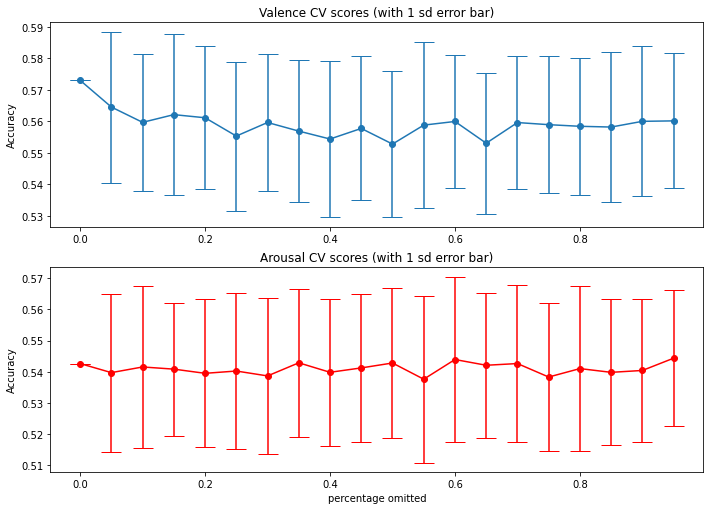

In [36]:
v_avg_res = [np.mean(x) for x in v_results]
a_avg_res = [np.mean(y) for y in a_results]
v_std_res = [np.std(x) for x in v_results]
a_std_res = [np.std(y) for y in a_results]

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.errorbar(cut_percentages, v_avg_res, yerr=v_std_res, capsize=10, marker="o")
ax1.set_title("Valence CV scores (with 1 sd error bar)")
ax1.set_ylabel("Accuracy")

ax2.errorbar(cut_percentages, a_avg_res, yerr=a_std_res, capsize=10, color="r", marker="o")
ax2.set_title("Arousal CV scores (with 1 sd error bar)")
ax2.set_xlabel("percentage omitted")
ax2.set_ylabel("Accuracy")

plt.show()